In [ ]:
%pip install matplotlib seaborn

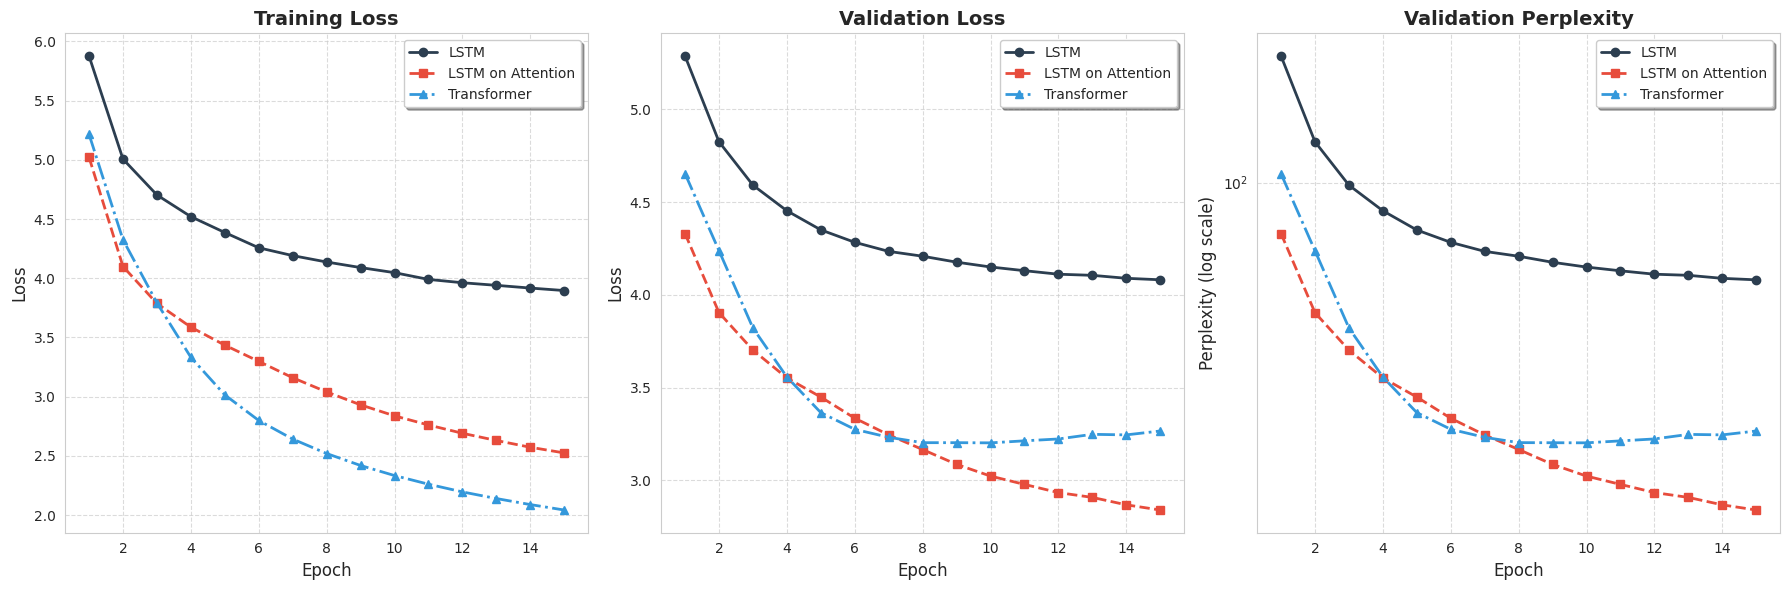

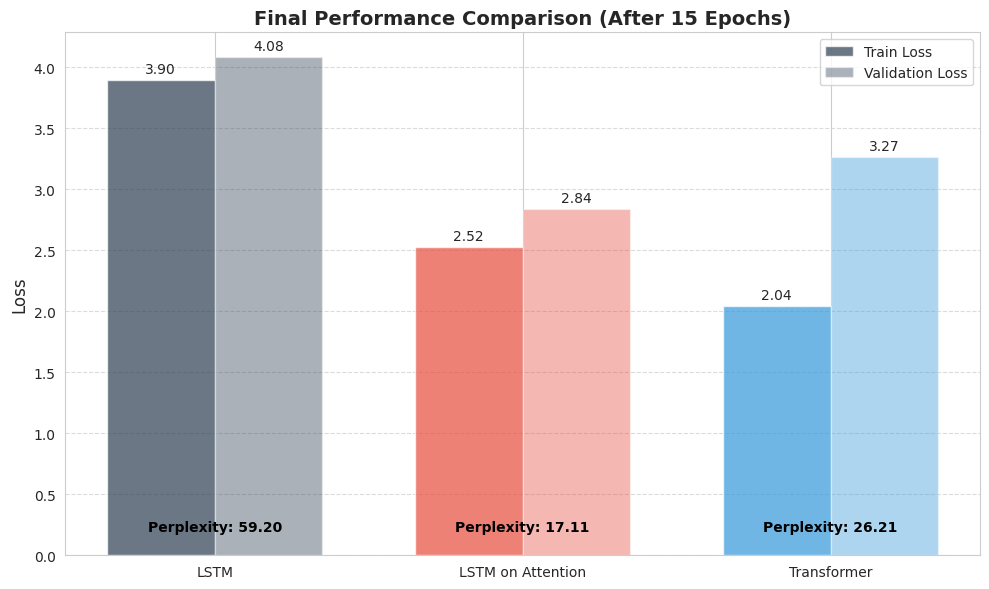

최종 성능 요약 (15 에포크 후):
모델                   | Train Loss   | Val Loss     | Val PPL     
LSTM                 | 3.8960       | 4.0810       | 59.2000     
LSTM on Attention    | 2.5250       | 2.8400       | 17.1150     
Transformer          | 2.0430       | 3.2660       | 26.2060     


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns

# 시각화 스타일 설정
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

# 로그 파일 경로
log_file_path = 'results.txt'

# 데이터를 저장할 딕셔너리 초기화
models = ['LSTM', 'LSTM on Attention', 'Transformer']
data = {model: {'train_loss': [], 'val_loss': [], 'val_ppl': []} for model in models}

# 현재 파싱 중인 모델
current_model = None

# 정규표현식 패턴
epoch_pattern = re.compile(r'Epoch (\d+): Train loss=(\d+\.\d+), Val loss=(\d+\.\d+), Val ppl=(\d+\.\d+)')
model_pattern = re.compile(r'# (.*)')
time_pattern = re.compile(r'\[(.*)\] Wall-clock training time : (\d+\.\d+) min')

# 로그 파일 읽기
with open(log_file_path, 'r') as f:
    for line in f:
        # 모델 이름 찾기
        model_match = model_pattern.match(line.strip())
        if model_match:
            current_model = model_match.group(1)
            continue
        
        # 에포크 정보 찾기
        epoch_match = epoch_pattern.match(line.strip())
        if epoch_match and current_model:
            epoch, train_loss, val_loss, val_ppl = epoch_match.groups()
            data[current_model]['train_loss'].append(float(train_loss))
            data[current_model]['val_loss'].append(float(val_loss))
            data[current_model]['val_ppl'].append(float(val_ppl))

# 색상 팔레트 정의
palette = {'LSTM': '#2C3E50', 'LSTM on Attention': '#E74C3C', 'Transformer': '#3498DB'}
linestyles = {'LSTM': '-', 'LSTM on Attention': '--', 'Transformer': '-.'}
markers = {'LSTM': 'o', 'LSTM on Attention': 's', 'Transformer': '^'}

# 시각화
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. 훈련 손실 그래프
for model in models:
    if data[model]['train_loss']:  # 데이터가 있는 경우만 그래프 그리기
        axes[0].plot(range(1, len(data[model]['train_loss'])+1), 
                 data[model]['train_loss'], 
                 marker=markers[model],
                 markersize=6,
                 linestyle=linestyles[model],
                 linewidth=2,
                 color=palette[model],
                 label=model)

axes[0].set_title('Training Loss', fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].legend(frameon=True, fancybox=True, shadow=True)

# 2. 검증 손실 그래프
for model in models:
    if data[model]['val_loss']:
        axes[1].plot(range(1, len(data[model]['val_loss'])+1), 
                 data[model]['val_loss'], 
                 marker=markers[model],
                 markersize=6,
                 linestyle=linestyles[model],
                 linewidth=2,
                 color=palette[model],
                 label=model)

axes[1].set_title('Validation Loss', fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].legend(frameon=True, fancybox=True, shadow=True)

# 3. 복잡도(Perplexity) 그래프 - y축 로그 스케일 사용
for model in models:
    if data[model]['val_ppl']:
        axes[2].plot(range(1, len(data[model]['val_ppl'])+1), 
                 data[model]['val_ppl'], 
                 marker=markers[model],
                 markersize=6,
                 linestyle=linestyles[model],
                 linewidth=2,
                 color=palette[model],
                 label=model)

axes[2].set_title('Validation Perplexity', fontweight='bold')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Perplexity (log scale)')
axes[2].set_yscale('log')  # 로그 스케일 적용
axes[2].grid(True, linestyle='--', alpha=0.7)
axes[2].legend(frameon=True, fancybox=True, shadow=True)

# 레이아웃 조정 및 저장
plt.tight_layout()
plt.savefig('model_performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 최종 성능 비교 표를 그래픽으로 표현
fig, ax = plt.subplots(figsize=(10, 6))

# 표 데이터 준비
models_labels = []
train_loss_values = []
val_loss_values = []
val_ppl_values = []

for model in models:
    if data[model]['train_loss']:
        models_labels.append(model)
        train_loss_values.append(data[model]['train_loss'][-1])
        val_loss_values.append(data[model]['val_loss'][-1])
        val_ppl_values.append(data[model]['val_ppl'][-1])

# 막대 그래프 그리기 - Train Loss와 Val Loss 비교
x = np.arange(len(models_labels))  # 모델 위치
width = 0.35  # 막대 너비

rects1 = ax.bar(x - width/2, train_loss_values, width, label='Train Loss', 
               color=[palette[model] for model in models_labels], alpha=0.7)
rects2 = ax.bar(x + width/2, val_loss_values, width, label='Validation Loss',
               color=[palette[model] for model in models_labels], alpha=0.4)

# 축 레이블, 타이틀 등 설정
ax.set_ylabel('Loss')
ax.set_title('Final Performance Comparison (After 15 Epochs)', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models_labels)
ax.legend()

# 막대 위에 값 표시
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3점 수직 오프셋
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

# Perplexity 값을 표에 추가
for i, model in enumerate(models_labels):
    ax.text(i, 0.2, f'Perplexity: {val_ppl_values[i]:.2f}', 
            ha='center', color='black', fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('final_performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 성능 요약 표 출력
print("최종 성능 요약 (15 에포크 후):")
print("=" * 60)
print(f"{'모델':<20} | {'Train Loss':<12} | {'Val Loss':<12} | {'Val PPL':<12}")
print("=" * 60)
for model in models:
    if data[model]['train_loss']:
        print(f"{model:<20} | {data[model]['train_loss'][-1]:<12.4f} | {data[model]['val_loss'][-1]:<12.4f} | {data[model]['val_ppl'][-1]:<12.4f}")